## Loading and pre-processing 
Load the parsed game data and the static hero roles data.  
We filter the games to only include **high_elo** and either **all_draft** or **captains_mode** games, where each team can pick and ban from the full selection of all hereos (unlike single_draft and random_draft which only offer a limited selection of hereos). Additionaly we remove games which don't include the prominant lane position of each hero (due to a parsing error).  
Afterwards we use the parsed lane-position (top,mid,bot,jungle) and the relative share of resources of each hero during the game to **predict the game position** from 1-5 (Carry, Midlaner, Offlaner, Soft Support, Hard Support). Following a simplified version of the approach in *"Role Identification for Accurate Analysis in Dota 2" (Demediuk et al. 2019)*

In [1]:
import json

#Load Games
with open('joined_all_matches.json', 'r') as file:
    raw_games = json.load(file)
print(f"all games: {len(raw_games)}")

#only high_elo, all_draft or captains_mode games
filtered_games = [game for game in raw_games if game.get('game_mode') in ('game_mode_all_draft','game_mode_captains_mode') and game.get('high_elo') == True]
print(f"high_elo, all_draft or captains_mode games: {len(filtered_games)}")

#remove games with missing lane information (parser error)
filtered_games = [game for game in filtered_games if 'lane' in next(iter(game['team_comp']['dire'].values()))]
#print(f"games with lane information: {len(filtered_games)}")

all games: 30797
high_elo, all_draft or captains_mode games: 23412


In [2]:
with open('opendota_heroes.json', 'r') as file:
    hero_data = json.load(file)

with open('official_roles.json', 'r') as file:
    role_data = json.load(file)

def get_name(hero_id):
    return hero_data[str(hero_id)]["localized_name"]

def get_roles(hero_id):
    return role_data[str(hero_id)]["roles"]

all_roles = list(get_roles(1).keys())
all_heroes = [hero_id for hero_id in hero_data.keys()]
print(f"There are currently {len(all_heroes)} heroes, each with any number of {len(all_roles)} roles ({', '.join(all_roles)}).")

There are currently 126 heroes, each with any number of 9 roles (Carry, Support, Nuker, Disabler, Jungler, Durable, Escape, Pusher, Initiator).


In [12]:
"""To predict the positions 1-5 (Carry to hard support) we first sort all Heroes by their relative share of total team rescources (gold and xp).
The first 3 hereos should then include a hero on each lane, which are the carries/laners.
The remaining 2 hereos should include a position 5 hard support on the safelane and a roaming position 4 support with no fixed lane.
"""

# 1 safelane, 2 mid, 3 offlane, 4 jungle --> 1 top, 2 mid, 3 bot, 4 jungle

#hardcarry midlaner offlane roamer hardsupport


def positional_lane(lane, is_radiant):
    if is_radiant:
        if lane == 1: #radiant safelane is bot
            return 3
        if lane == 3: #radiant offlane is top
            return 1
    return lane

def predict_positions(team_dict, is_radiant:bool):
    total_gold_per_min = sum([stats['gold_per_min'] for stats in team_dict.values()])
    total_xp_per_min = sum([stats['xp_per_min'] for stats in team_dict.values()])
    total_rescource_per_min_team = total_gold_per_min + total_xp_per_min
    team = []
    for hero_id, stats in team_dict.items():
        total_rescources_player = stats['gold_per_min'] + stats['xp_per_min']
        relative_rescources = total_rescources_player / total_rescource_per_min_team
        lane = stats['lane']
        team.append((hero_id, lane, relative_rescources))
    
    sorted_by_rescources = sorted(team, key=lambda x: x[2],reverse=True)
    positions = {hero_id:0 for hero_id in team_dict.keys()}
    
    #first 3 players should include each lane (safe, mid, off)
    if not sorted(list(p[1] for p in sorted_by_rescources[:3])) == [1,2,3]:
        return False
   
    #last 2 players should include hardsupport on the safelane
    if not (sorted_by_rescources[3][1] == 1 or sorted_by_rescources[4][1] == 1):
        return False
    
    for hero_id, lane, _ in sorted_by_rescources[:3]:
        positions[hero_id] = lane #carries 1-3
    for hero_id, lane, _ in sorted_by_rescources[3:]:
        positions[hero_id] = 5 if lane == 1 else 4 #hardsupport (pos 5) in safelane (lane 1), remaining pos 4
    return positions

fail_pred = 0
filtered_games_with_position = []
for game in filtered_games:
    radiant_team = game['team_comp']['radiant']
    dire_team = game['team_comp']['dire']
    radiant_win = game['radiant_win']
    if radiant_positions := predict_positions(radiant_team, is_radiant=True):
        if dire_postions := predict_positions(dire_team, is_radiant=False):
            filtered_games_with_position.append({'radiant':radiant_positions,'dire':dire_postions,'radiant_win':game['radiant_win']})
            continue
    fail_pred +=1

n_games = len(filtered_games)
n_pred_games = n_games - fail_pred
print(f"Could predict hero positions for {n_pred_games} out of {n_games} games ({int((n_pred_games/n_games)*100)}%)")

Could predict hero positions for 13828 out of 17907 games (77%)


In [11]:
all_lanes = set()
radiant_lanes, dire_lanes = {x:0 for x in range(1,5)}, {x:0 for x in range(1,5)}
for game in filtered_games:
    for team in ['radiant','dire']:
        for player, stats in game['team_comp'][team].items():
            all_lanes.add(stats['lane'])
            if team == 'radiant':
                radiant_lanes[stats['lane']] += 1
            if team == 'dire':
                dire_lanes[stats['lane']] += 1

print(radiant_lanes, dire_lanes)

{1: 35639, 2: 18909, 3: 34895, 4: 92} {1: 35508, 2: 18680, 3: 35204, 4: 143}


In [8]:
print(filtered_games[0])

{'match_id': 8108259917, 'patch': 56, 'radiant_win': True, 'duration': 1757, 'high_elo': True, 'lobby_type': 'lobby_type_normal', 'game_mode': 'game_mode_all_draft', 'leavers': 0, 'draft': [['dire_pick', 80], ['dire_pick', 10], ['radiant_pick', 135], ['radiant_pick', 58], ['dire_pick', 21], ['radiant_pick', 25], ['dire_pick', 111], ['radiant_pick', 31], ['dire_pick', 100], ['radiant_pick', 6], ['radiant_ban', 27], ['radiant_ban', 136], ['radiant_ban', 37], ['radiant_ban', 76], ['radiant_ban', 101], ['dire_ban', 30], ['dire_ban', 61], ['dire_ban', 75]], 'team_comp': {'radiant': {'58': {'gold_per_min': 301, 'xp_per_min': 434, 'lane': 3}, '25': {'gold_per_min': 833, 'xp_per_min': 1105, 'lane': 2}, '31': {'gold_per_min': 299, 'xp_per_min': 454, 'lane': 1}, '6': {'gold_per_min': 600, 'xp_per_min': 572, 'lane': 1}, '135': {'gold_per_min': 533, 'xp_per_min': 526, 'lane': 3}}, 'dire': {'10': {'gold_per_min': 277, 'xp_per_min': 293, 'lane': 1}, '80': {'gold_per_min': 420, 'xp_per_min': 493, 'la

In [4]:
#Preprocessing results in list of high elo games with draft and meta information
#print(filtered_games[0])
#and a subset list of games with predicted semantic position of each hero (1-5, carry to support)
#print(filtered_games_with_position[0])

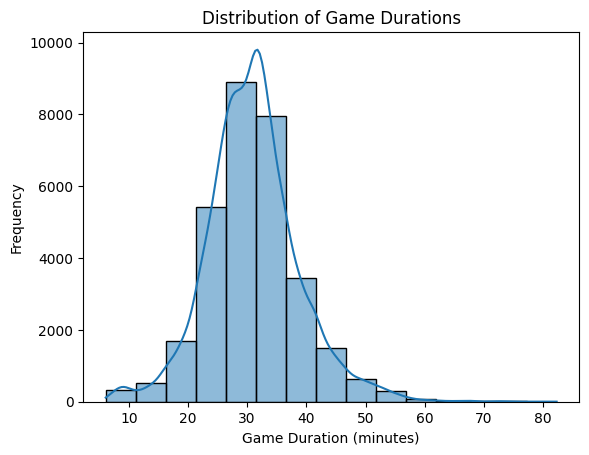

In [4]:
#visualize game durations
import seaborn as sns
import matplotlib.pyplot as plt

game_durations = [game['duration']/60 for game in raw_games]

# Plot histogram
sns.histplot(game_durations, bins=15, kde=True)

# Labels and title
plt.xlabel("Game Duration (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Game Durations")
plt.show()

## Hero Analysis
Visualization of total hero pick count and winrate of pairs of hereos.    
Comparing the winrate heatmap with results of *"To win or not to win? A prediction model to determine the outcome of
a DotA2 match"(Kalyanaraman 2015)* and the heatmap of all available games, suggests that the current count of 12630 high-elo matches may be to low for accurate synergy analysis.

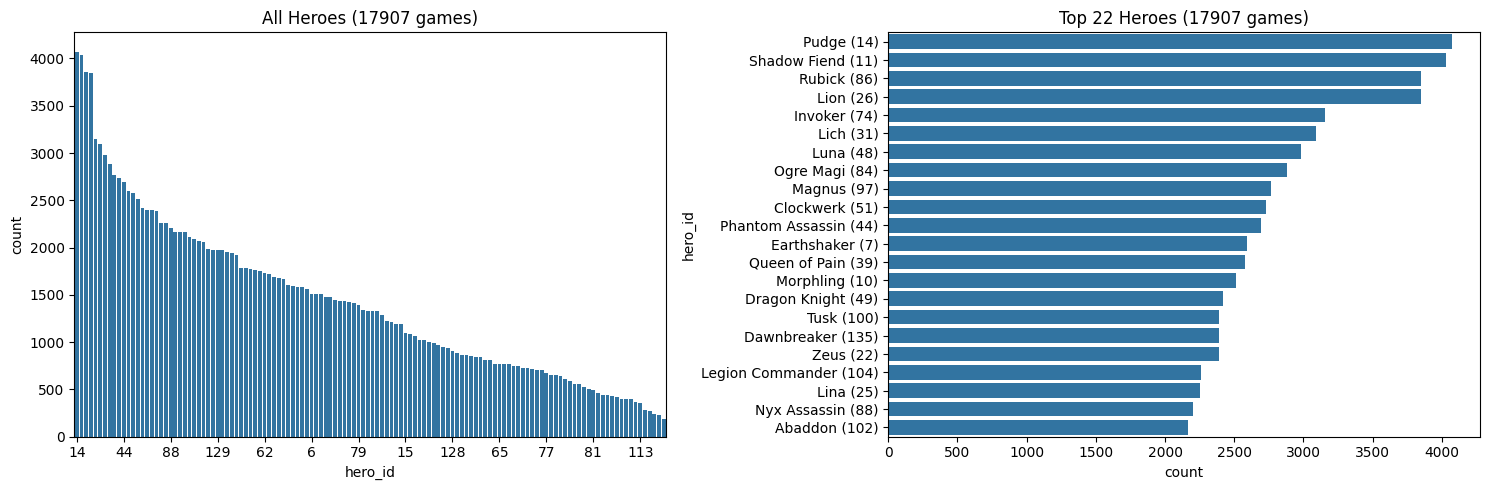

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

n_games = len(filtered_games)
heroes_count = {hero_id:0 for hero_id in all_heroes}

for game in filtered_games:
    heroes_both_teams = list(game['team_comp']['radiant'].keys()) + list(game['team_comp']['dire'].keys())
    for hero in heroes_both_teams:
        heroes_count[hero] += 1

h_f = pd.DataFrame(list(heroes_count.items()), columns=['hero_id', 'count'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=h_f.sort_values('count', ascending=False) , x='hero_id', y='count',ax=ax[0])
ax[0].set_xticks(range(0, len(h_f), 10))
ax[0].set_title(f"All Heroes ({n_games} games)")

sns.barplot(data=h_f.nlargest(22, 'count'), x='count', y='hero_id',ax=ax[1])
ax[1].set_yticks(range(22),labels=[f"{get_name(id)} ({id})" for id in h_f.nlargest(22, 'count').hero_id])
ax[1].set_title(f"Top 22 Heroes ({n_games} games)")

plt.tight_layout()
plt.show()

(126, 9)


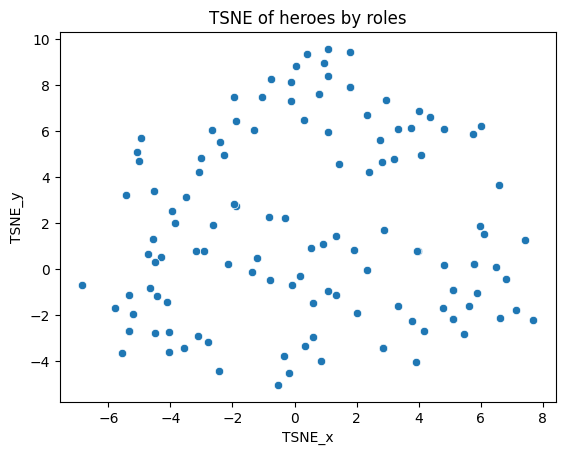

In [6]:
import matplotlib.pyplot as plt
import sklearn.manifold._t_sne
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import numpy as np

heroes_by_roles = []
for hero_id in all_heroes:
    hero_encoded = np.zeros(len(all_roles))
    roles = get_roles(hero_id)
    for role, value in roles.items():
        hero_encoded[all_roles.index(role)] = value
    heroes_by_roles.append(hero_encoded)

#2D TSNE
X = np.array(heroes_by_roles)
print(X.shape)
X_embedded = sklearn.manifold._t_sne.TSNE(n_components=2, random_state=1, perplexity=30).fit_transform(X)
X_embedded_df = pd.DataFrame(X_embedded, columns=['TSNE_x', 'TSNE_y'])
sns.scatterplot(x='TSNE_x', y='TSNE_y', data=X_embedded_df)
plt.title(f"TSNE of heroes by roles")
plt.show()

In [30]:
import numpy as np
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt

def calc_pair_winrate_matrix_same_team(games):
    pair_wincount_matrix = np.zeros((len(all_heroes), len(all_heroes)))
    pair_matchcount_matrix = np.zeros((len(all_heroes), len(all_heroes)))
    
    hero_index = lambda x : all_heroes.index(x)
    
    for game in games:
        for team, won in [("radiant", game["radiant_win"]), ("dire", not game["radiant_win"])]:
            heroes = list(game["team_comp"][team].keys())
            for a, b in combinations(heroes, 2):
                a, b = hero_index(a), hero_index(b)
                pair_matchcount_matrix[a][b] += 1
                pair_matchcount_matrix[b][a] += 1
                if won:
                    pair_wincount_matrix[a][b] += 1
                    pair_wincount_matrix[b][a] += 1

    with np.errstate(divide='ignore', invalid='ignore'):  # Avoid division by zero
        pair_winrate_matrix = np.nan_to_num(pair_wincount_matrix / pair_matchcount_matrix)
    return pair_winrate_matrix

def calc_pair_winrate_matrix_opposite_team(games):
    pair_wincount_matrix = np.zeros((len(all_heroes), len(all_heroes)))
    pair_matchcount_matrix = np.zeros((len(all_heroes), len(all_heroes)))
    
    hero_index = lambda x : all_heroes.index(x)

    for game in games:
        if game["radiant_win"]:
            winning_team, losing_team = 'radiant', 'dire'
        else:
            winning_team, losing_team = 'dire', 'radiant'
        for hero_a in list(game['team_comp'][winning_team].keys()):
            for hero_b in list(game['team_comp'][losing_team].keys()):
                a, b = hero_index(hero_a), hero_index(hero_b)
                pair_matchcount_matrix[a][b] += 1
                pair_matchcount_matrix[b][a] += 1
                pair_wincount_matrix[a][b] += 1

    with np.errstate(divide='ignore', invalid='ignore'):  # Avoid division by zero
        pair_winrate_matrix = np.nan_to_num(pair_wincount_matrix / pair_matchcount_matrix)
    return pair_winrate_matrix

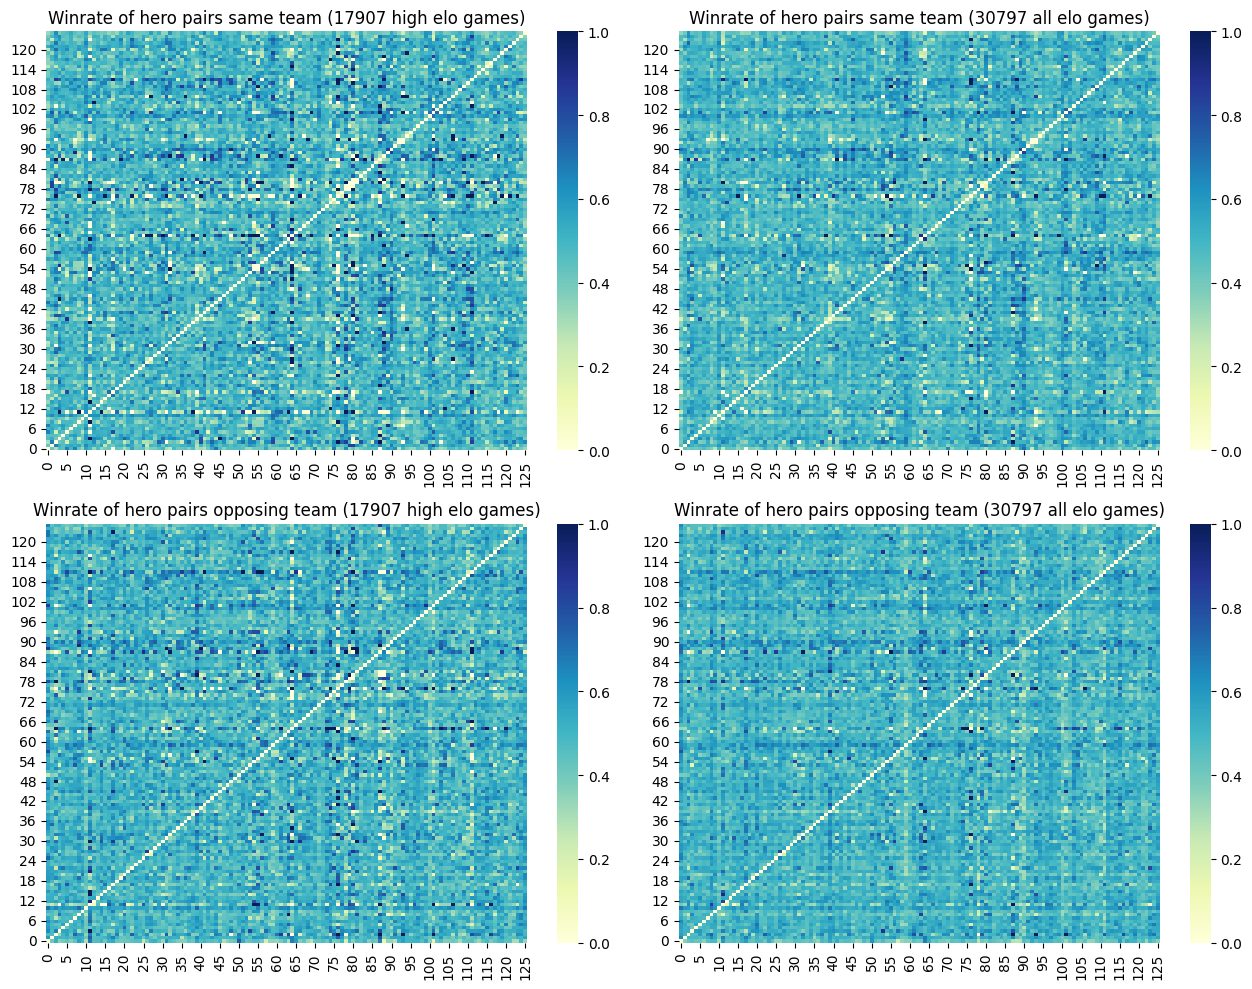

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(13, 10))

sns.heatmap(calc_pair_winrate_matrix_same_team(filtered_games) ,cmap='YlGnBu', ax=ax[0][0])
ax[0][0].set_title(f"Winrate of hero pairs same team ({len(filtered_games)} high elo games)")
ax[0][0].invert_yaxis()

sns.heatmap(calc_pair_winrate_matrix_same_team(raw_games), cmap='YlGnBu', ax=ax[0][1])
ax[0][1].set_title(f"Winrate of hero pairs same team ({len(raw_games)} all elo games)")
ax[0][1].invert_yaxis()

sns.heatmap(calc_pair_winrate_matrix_opposite_team(filtered_games) ,cmap='YlGnBu', ax=ax[1][0])
ax[1][0].set_title(f"Winrate of hero pairs opposing team ({len(filtered_games)} high elo games)")
ax[1][0].invert_yaxis()

sns.heatmap(calc_pair_winrate_matrix_opposite_team(raw_games), cmap='YlGnBu', ax=ax[1][1])
ax[1][1].set_title(f"Winrate of hero pairs opposing team ({len(raw_games)} all elo games)")
ax[1][1].invert_yaxis()

plt.tight_layout()
plt.show()

## Draft representation for clustering using semantic positions  
We represent the each draft as a matrix, with one column for each hero, ordered by their semantic position (1-5, hard carry to support).  
Two different encodings are utilized, one where each row represents a hero role and another where each row just represents a hero(id).  
This results in two matrix encodings for a draft, either 8x5 (multiple-hot hero roles) or 126x5 (one-hot hero_id).

In [13]:
#Version 1, one-hot encode hero_id for each player by position
import numpy as np

hero_index = lambda x : all_heroes.index(x)

def encode_hero_comp_as_matrix(team):
    matrix = np.zeros((len(all_heroes),5))
    for hero_id, position in team.items():
        matrix[all_heroes.index(hero_id)][position-1] = 1
    return matrix

encoding_type = 'Heroes'
encoded_drafts = []
for game in filtered_games_with_position:
    for team in ('radiant', 'dire'):
        encoded_drafts.append((encode_hero_comp_as_matrix(game[team]), game['radiant_win'] if team == 'radiant' else not game['radiant_win']))

In [16]:
#Version 2, multiple-hot encode hero_roles for each player by position
import numpy as np

hero_index = lambda x : all_heroes.index(x)

def encode_role_comp_as_matrix(team):
    matrix = np.zeros((len(all_roles),5))
    for hero_id, position in team.items():
        roles = get_roles(hero_id)
        for role, value in roles.items():
            matrix[all_roles.index(role)][position-1] = value
    return matrix

encoding_type = 'Roles'
encoded_drafts = []
for game in filtered_games_with_position:
    for team in ('radiant', 'dire'):
        encoded_drafts.append((encode_role_comp_as_matrix(game[team]), game['radiant_win'] if team == 'radiant' else not game['radiant_win']))

In [39]:
#Version 3, basic encoding

import numpy as np

hero_index = lambda x : all_heroes.index(x)

def encode_comp_as_matrix(team):
    matrix = np.zeros(len(all_heroes))
    for hero_id, stats in team.items():
        matrix[hero_index(hero_id)] = 1
    return matrix

encoding_type = 'Basic'
encoded_drafts = []
for game in filtered_games:
    for team in ('radiant', 'dire'):
        encoded_drafts.append((encode_comp_as_matrix(game['team_comp'][team]), game['radiant_win'] if team == 'radiant' else not game['radiant_win']))

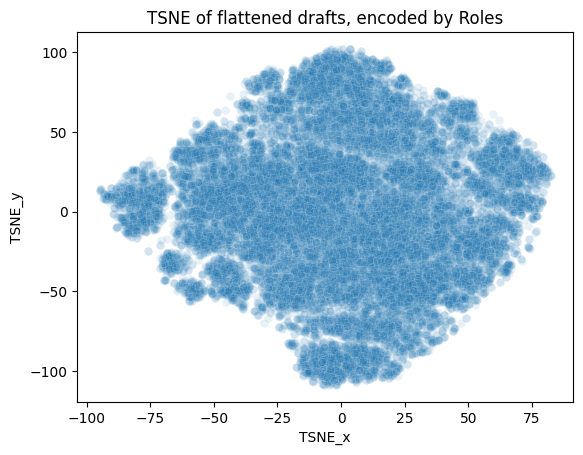

In [17]:
#2D TSNE embedding of chosen encoding, reused in clustering visualization
import matplotlib.pyplot as plt
import sklearn.manifold._t_sne
import seaborn as sns
import pandas as pd

X = np.array([draft.flatten() for draft, _ in encoded_drafts])
#X_flattened = X.reshape(X.shape[0], -1)
X_embedded = sklearn.manifold._t_sne.TSNE(n_components=2, random_state=1, perplexity=50).fit_transform(X)
X_embedded_df = pd.DataFrame(X_embedded, columns=['TSNE_x', 'TSNE_y'])

sns.scatterplot(x='TSNE_x', y='TSNE_y', data=X_embedded_df, alpha=0.1)
plt.title(f"TSNE of flattened drafts, encoded by {encoding_type}")
plt.show()

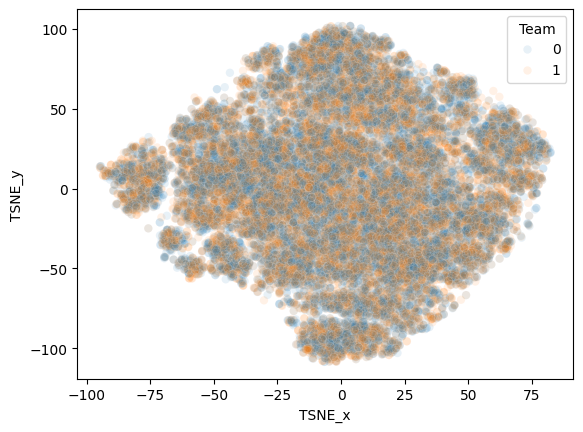

          TSNE_x     TSNE_y  Team    Win  diff
0      46.550575 -43.420792     0   True    -1
1      22.777895 -88.018547     1  False     1
2      14.978180  56.085533     0  False     0
3      51.165085 -32.691917     1   True     0
4      33.079727  22.185930     0  False     0
...          ...        ...   ...    ...   ...
27651  46.256905  12.139855     1  False     1
27652 -71.969055   9.894174     0   True    -1
27653   3.282435  54.153786     1  False     1
27654  62.041477  44.468510     0   True    -1
27655 -13.668077  56.178745     1  False     1

[27656 rows x 5 columns]


In [18]:
#check team distribution
X_embedded_df['Team'] = np.arange(len(X_embedded_df)) % 2
X_embedded_df['Win'] = np.array([win for draft, win in encoded_drafts])
X_embedded_df['diff'] = X_embedded_df['Team'] - X_embedded_df['Win']
sns.scatterplot(x='TSNE_x', y='TSNE_y', data=X_embedded_df, hue='Team',alpha=0.1)
plt.show()
#print(X_embedded_df)

## Draft Clustering  
We test multiple different clustering algorithms and visualize both the clusters and their (pairwise) winrates.  
Clustering is done on one of the encodings chosen in the previous step.  
**The cell above needs to be executed once to enable visualization of the chosen clustering**

In [19]:
#flatten each matrix to get shape of (samples, features) and seperate win bool from drafts
#note that order is preserved to calculate pairwise winrate (every two drafts belong to one game)
wins = np.array([win for _, win in encoded_drafts])
X = np.array([draft for draft, _ in encoded_drafts])
X_flattened = X.reshape(X.shape[0], -1)

In [ ]:
# START Cluster Algorithms

In [29]:
from sklearn.cluster import KMeans

cluster_type = 'KMeans'
clustering = KMeans(n_clusters=4, n_init=10, random_state=5, init='random').fit(X_flattened)
cluster_labels = clustering.labels_

In [44]:
center_1 = clustering.cluster_centers_[2]

def custom_centers(X, n_clusters, random_state):
    fixed_centers = np.stack([center_0, center_1], axis=0)
    n_samples = X.shape[0]
    seeds = random_state.choice(
        n_samples,
        size=n_clusters - len(fixed_centers),
        replace=False,
    )
    return np.concatenate([X[seeds], fixed_centers], axis=0)

In [16]:
r_s = np.random.RandomState()
print(custom_centers(X_flattened, 6, r_s).shape)

(6, 630)


In [27]:
from sklearn.cluster import BisectingKMeans
# n_clusters=5, init='k-means++', random_state=1), Silhouette Score: 0.015, Calinski-Harabasz Index: 152.05

cluster_type = 'BisectingKMeans'
clustering = BisectingKMeans(n_clusters=3, init='k-means++', n_init=10, random_state=5).fit(X_flattened)
cluster_labels = clustering.labels_
center_0 = clustering.cluster_centers_[0]
print(center_0.shape)

(45,)


In [44]:
from sklearn.cluster import SpectralClustering

cluster_type = 'SpectralClustering'
clustering = SpectralClustering(n_clusters=8, random_state=1, n_jobs=-1).fit(X_flattened)
cluster_labels = clustering.labels_

In [126]:
from sklearn.cluster import AgglomerativeClustering
#{‘ward’, ‘complete’, ‘average’, ‘single’},
link='ward'
cluster_type = f"AgglomerativeClustering, linkage:{link}"
clustering = AgglomerativeClustering(n_clusters=6, linkage=link).fit(X_flattened)
cluster_labels = clustering.labels_

In [116]:
from sklearn.cluster import DBSCAN

#nur ein "-1" Cluster?

cluster_type = 'DBSCAN'
clustering = DBSCAN(n_jobs=-1).fit(X_flattened)
cluster_labels = clustering.labels_

In [104]:
from sklearn.cluster import HDBSCAN

cluster_type = 'HDBSCAN'
clustering = HDBSCAN(n_jobs=-1).fit(X_flattened)
cluster_labels = clustering.labels_

In [106]:
from sklearn.cluster import Birch

cluster_type = 'Birch'
#threshold: very low promotes splitting, default=0.5
clustering = Birch(n_clusters=10, threshold=0.5).fit(X_flattened)
cluster_labels = clustering.labels_

In [108]:
# didn't finish in ~5min
from sklearn.cluster import AffinityPropagation
cluster_type = 'AffinityPropagation'
clustering = AffinityPropagation().fit(X_flattened)

from sklearn.cluster import OPTICS
cluster_type = 'OPTICS'
clustering = OPTICS(n_jobs=-1).fit(X_flattened)

from sklearn.cluster import MeanShift
cluster_type = 'MeanShift'
clustering = MeanShift(cluster_all=False, n_jobs=-1).fit(X_flattened)

cluster_labels = clustering.labels_

In [ ]:
# END Cluster Algorithms

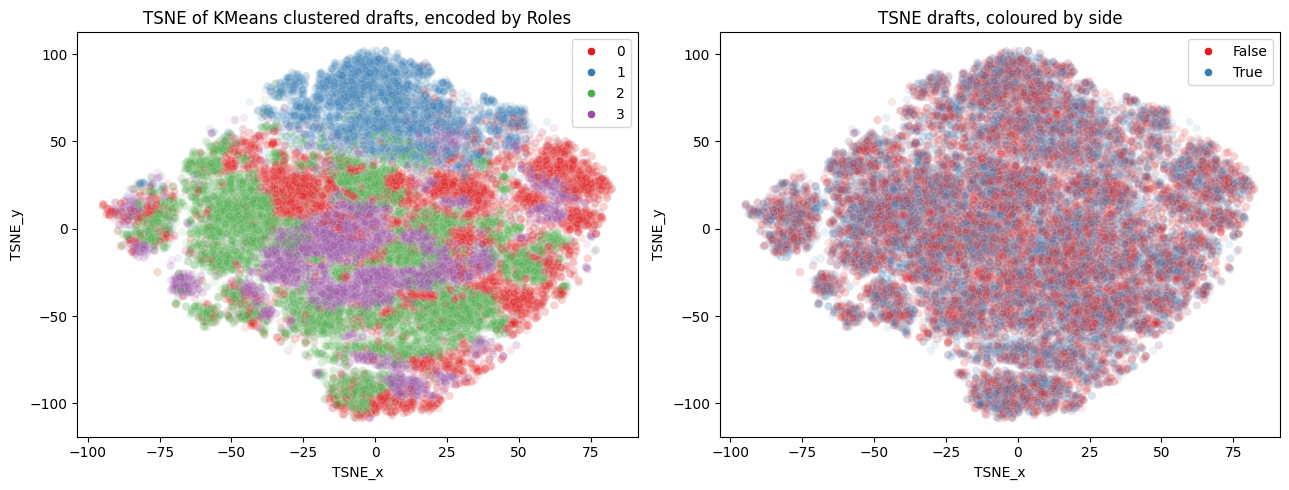

Silhouette Score: 0.056
Calinski-Harabasz Index: 1280.70


In [30]:
#TSNE visualization of clustering, reuses embedding from the "Draft representation" Step
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn.manifold._t_sne
import seaborn as sns
import pandas as pd

c_pal = 'Set1'

X_embedded_df['Cluster'] = cluster_labels
X_embedded_df['Win'] = wins
X_embedded_df['Team'] = np.arange(len(X_embedded_df)) % 2
X_embedded_df['diff'] = X_embedded_df['Team'] - X_embedded_df['Cluster']

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sns.scatterplot(x='TSNE_x', y='TSNE_y', data=X_embedded_df, hue='Cluster', palette=c_pal, alpha=0.1, ax=ax[0])
ax[0].set_title(f"TSNE of {cluster_type} clustered drafts, encoded by {encoding_type}")
leg = ax[0].legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)

sns.scatterplot(x='TSNE_x', y='TSNE_y', data=X_embedded_df, hue='Win', palette=c_pal, alpha=0.1, ax=ax[1])
ax[1].set_title(f"TSNE drafts, coloured by side")
leg = ax[1].legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

print(f"Silhouette Score: {metrics.silhouette_score(X_flattened, cluster_labels, metric='euclidean'):.3f}")
print(f"Calinski-Harabasz Index: {metrics.calinski_harabasz_score(X_flattened, cluster_labels):.2f}")

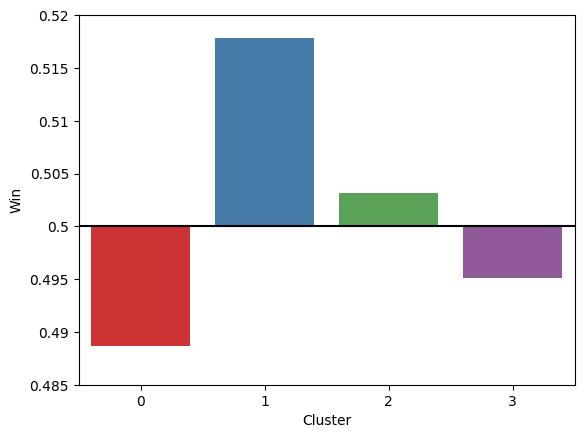

Cluster 0: 6966 datapoints
Cluster 1: 4380 datapoints
Cluster 2: 10036 datapoints
Cluster 3: 6274 datapoints


In [31]:
#Winrate of each cluster/team
group_by = 'Cluster' # 'Team'
cluster_winrates = X_embedded_df.groupby(group_by)["Win"].mean().to_frame()
adj_cluster_winrates = cluster_winrates - 0.5
sns.barplot(data=adj_cluster_winrates, x=group_by, y='Win', hue=group_by, palette=c_pal, legend=False)
plt.axhline(y = 0, color = 'black', linestyle = '-')
# Get current y-ticks
current_ticks = plt.gca().get_yticks()

# Modify the y-ticks to add 0.5
plt.gca().set_yticks(current_ticks) 
plt.gca().set_yticklabels([str(tick + 0.5) for tick in current_ticks])
plt.ylim = (-1, 1)
plt.show()

cluster_counts = X_embedded_df[group_by].value_counts().sort_index()

# Print the count for each cluster
for cluster, count in cluster_counts.items():
    print(f"{group_by} {cluster}: {count} datapoints")

In [37]:
red = clustering.cluster_centers_[0]
blue = clustering.cluster_centers_[1]
diff = red - blue
for i in range(0, len(diff), 9):
    print(f"Player Position {int(i/9) + 1}:")
    for role, value in zip(all_roles, diff[i:i+9]):
        if abs(value) > 0.9:
            print(f"\t{role}: {value:.3f}")

Player Position 1:
	Carry: 1.380
	Nuker: -1.418
Player Position 2:
Player Position 3:
Player Position 4:
	Carry: 0.936
Player Position 5:
	Jungler: -1.300
	Escape: 1.306


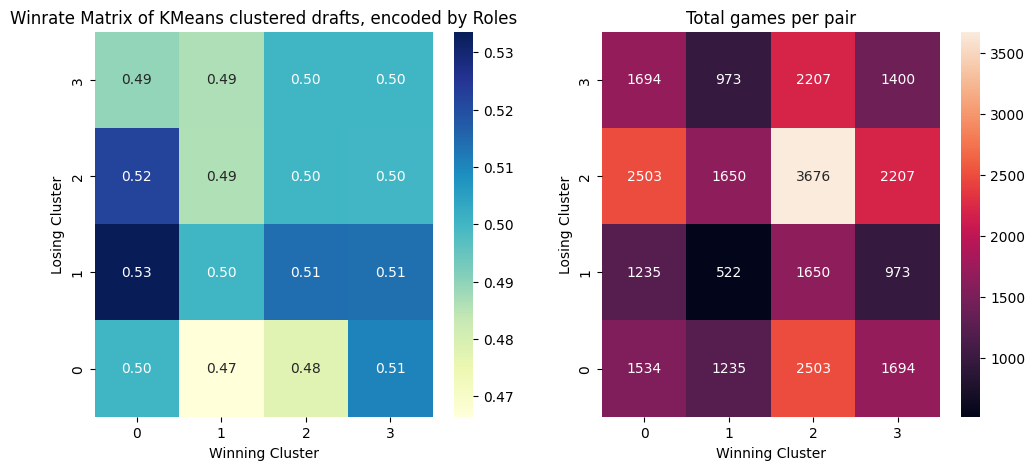

In [32]:
#TODO calculate avergae of winrate matrix per column and row weighted by gamecount
# Calculate pairwise winrate matrix of chosen clustering
clusters = X_embedded_df["Cluster"].unique()
cluster_indices = {cluster: i for i, cluster in enumerate(sorted(clusters))}
size = len(clusters)
win_matrix = np.zeros((size, size), dtype=int)
total_matrix = np.zeros((size, size), dtype=int)

# Iterate over games (2 consecutive rows per game)
for i in range(0, len(X_embedded_df), 2):
    win_cluster = X_embedded_df.iloc[i + 1]["Cluster"] if X_embedded_df.iloc[i + 1]["Win"] else X_embedded_df.iloc[i]["Cluster"]
    lose_cluster = X_embedded_df.iloc[i]["Cluster"] if X_embedded_df.iloc[i + 1]["Win"] else X_embedded_df.iloc[i + 1]["Cluster"]

    win_idx, lose_idx = cluster_indices[win_cluster], cluster_indices[lose_cluster]

    win_matrix[win_idx, lose_idx] += 1
    total_matrix[win_idx, lose_idx] += 1
    total_matrix[lose_idx, win_idx] += 1

winrate_matrix = np.divide(win_matrix, total_matrix, where=total_matrix > 0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(winrate_matrix ,cmap='YlGnBu', fmt='.2f', annot=True, ax=axes[0], xticklabels=cluster_indices.keys(), yticklabels=cluster_indices.keys())
axes[0].set_title(f"Winrate Matrix of {cluster_type} clustered drafts, encoded by {encoding_type}")
axes[0].set_xlabel('Winning Cluster')
axes[0].set_ylabel('Losing Cluster')
axes[0].invert_yaxis()

sns.heatmap(total_matrix, annot=True, ax=axes[1], fmt='g', xticklabels=cluster_indices.keys(), yticklabels=cluster_indices.keys())
axes[1].set_title("Total games per pair")
axes[1].set_xlabel('Winning Cluster')
axes[1].set_ylabel('Losing Cluster')
axes[1].invert_yaxis()